# Random Numbers and Monte Carlo Markov Chains

Please ensure you have watched the Chapter 7 video(s).

## You will learn the following things in this Chapter

- How to generate random data
- Understand the basic idea behind Monte Carlo Markov Chains and why they are useful
- How to construct a basic Metropolis algorithm
- The issues surrounding convergence, and how to test for it
- How to use MCMC to draw random points from a Bayesian posterior
- How to use Python programming to do the above.
- After completing this notebook you will be able to start CA 2.

***

# Bayes Theorem with complicated prior distributions

In Chapter 6 we derived some analytical expressions to get the mean and varaince of some parameter using a sample, a prior and Bayes theorem.  But what if our prior and likelihood distributions weren’t so well-behaved as the ones discussed previously? Sometimes it is most accurate to model our data or our prior beliefs using distributions which don’t have convenient shapes. What if our likelihood were best represented by a distribution with two peaks, and for some reason we wanted to account for some really wacky prior distribution, impossible to solve for analytically.

It turns out we can use something called a Monte Carlo Markov Chain (MCMC) to "sample" our posterior distribution without knowing the underlying distributions. 

## Monte Carlo

A Monte Carlo (MC) simulation is a computer model where we generate many different data sets (either from a model or the probability distribution of the real data) and analyse them like the real data.

The many different data sets are generated using random number generators

Imagine we're in a well known burger chain and want to guarantee that the super burger on offer has a particular mean weight. It’s not feasible to weigh every super burger produced, so we use sampling techniques to randomly choose 100 super burgers from the shop. We calculate the mean of these 100 burgers and say that the population mean falls within a margin of error from what the mean of our sample is.

The uses of MC are incredibly wide-ranging, and have led to a number of groundbreaking discoveries in the fields of physics, game theory, and finance.  

### Origin of Monte Carlo

The Monte Carlo concept was invented by the mathematician Stanislaw Ulam working on the Manhattan Project in World War II.  He used the tools of random sampling to model likelihoods of outcomes, originally applied to a card game (Monte Carlo Solitaire).  This is what he thought:

What if we wanted to find the probability of getting blackjack (an ace and ten card)? Normally we would find the probability by counting the number of possible combinations of cards that would give Blackjack and dividing by all combinations of cards.  Ok sounds good.

But what if there are more than 52 cards in the deck, or we don't know how many cards are in the deck.  Right, so another option to get the probability is to sit down and play a 100/1000 games and record the outcomes and how many times we get Blackjack. But this would take a long time if we needed larger samples/better statistics.

What to do? Since we know from Chapter 3 that "As the number of identically distributed, randomly generated variables increases, their sample mean (average) approaches their theoretical mean" he realised we could use random sampling of the 100 games to make a data set much bigger and get closer to the true (population) value!

# Generating Random Numbers

The most random way of constructing a simple point process is to assume that each event happens independently of every other event. We also need to assume that there is a constant probability per unit time of an event happening. (You may recognise this as a Poisson process).

But when you ask people to pick a number at random, it turns out that the distribution isn't quite as random as we might expect - it is well known amongst magicians that if you ask people to pick a number between 1 and 10, far more people choose one number over any other number.

When looking at your data to test if it is random or not can be very difficult to tell by eye. What is needed is a rigorous statistical analysis to confirm if the distribution in your image or data looks random by chance.  Note also that even simple random processes, coincidences happens more frequently than one would naively expect.

In python we can use `from numpy import random`. We can generate random integers, and generate random numbers from a distribution for example, Binomial, Poisson, Gaussian etc. The `numpy` function `random.normal` allows you to do this, or we can use the `scipy.stats` function `norm`.

*Tip: When using code to generate $N$ random numbers, try it out on a small number first to check your code is doing what you want it to do.  It can take a long time to run in Colab.*

### <font color=#4290C4>Example</font>

Generate 5000 random datasets from a gaussian distribution with mean $\mu=3$ and standard deviation $\sigma = 1.0$. Plot the datasets.

###  <font color=#c38241> Solution</font>

Click below to see the solution.

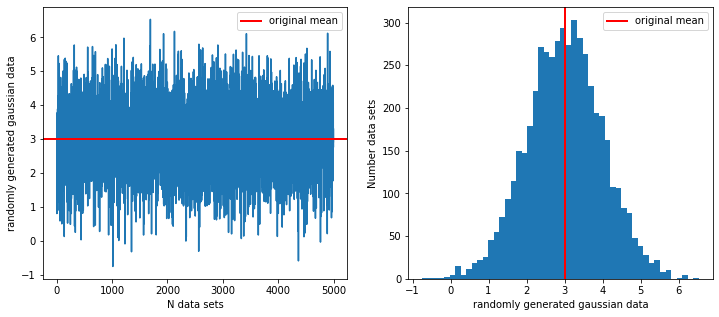

In [10]:
import numpy as np
import pylab as plt

%matplotlib inline

# set up our mean and sigma
mu = 3.
sigma = 1.0
nPoints=5000  # nice large number so that we can start to approximate the PDF

randomG_data = np.random.normal(mu,sigma,size=nPoints)

# what does this data look like - let's plot it!
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(randomG_data)
plt.xlabel('N data sets')
plt.ylabel('randomly generated gaussian data')
plt.axhline(3.0,label='original mean',c='r',lw=2)
plt.legend()

plt.subplot(122)
plt.hist(randomG_data,bins=50)
plt.axvline(3.0,label='original mean',c='r',lw=2)
plt.xlabel('randomly generated gaussian data')
plt.ylabel('Number data sets')
plt.legend()


### <font color=#4290C4>Example</font>

Generate 1000 sets of random data to represent flipping a coin 10 times and getting 5 heads.  Plot the distribution.


###  <font color=#c38241> Solution</font>

Click below to see the solution.

Flipping a coin is a Binomial distribution with $N=10$ and $\nu=5$.

Text(0, 0.5, 'Frequency')

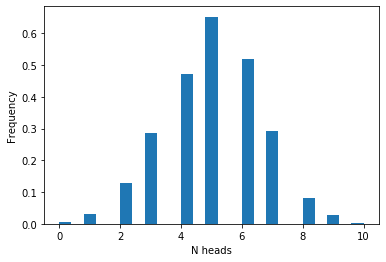

In [11]:
N=10.
nu=5.

p = nu/N

data = np.random.binomial(N,p,1000)

plt.hist(data,bins=25,density=True)

plt.xlabel('N heads')
plt.ylabel('Frequency')

### <font color=#4290C4>Example</font>

A company drills 9 wild-cat oil exploration wells, each with an estimated probability of success of 0.1. All nine wells fail. What is the probability of that happening? Tip: generate some random data.

###  <font color=#c38241> Solution</font>

Click below to see the solution.

Let’s do 20,000 trials of the model, and count the number that generate zero positive results. This is a binomial distribution (pass/fail) with N=9 and $\mu =0.1$.

In [12]:
N=9
p = 0.1
N_trials = 20000

# count the number of trials with binomial outcome = 0
n_fails = sum(np.random.binomial(N,p,N_trials)==0)

prob = n_fails/np.float(N_trials)

print('Number of times that all 20000 wells fail is {:.3f}'.format(n_fails))
print('Probability wells fail is n(fail)/N(trials) {:.3f}'.format(prob))

Number of times that all 20000 wells fail is 7840.000
Probability wells fail is n(fail)/N(trials) 0.392


*** 

# Monte Carlo Markov Chain

A Markov chain is a sequence of events that are related probabalistically, where each outcome determines what happens next.

- Each future step in the sequence is related only to the present step
- It should have no memory of the steps before


The main goal of MCMC is to provide an approximation to a probability distribution. This is extremely useful. Although we have random number generators for uniform, normal, and sometimes binomial, Bernoulli or Poisson distributions, these can only get us so far. For example, the kind of pdfs that commonly appear in Bayesian analysis are often complicated functions, which are hard, or even impossible, to put in an analytic pdf form. MCMC allows us to get around these problems.

MCMCs stochastically explore the parameter space in such a way that the histogram of their samples produces the target distribution.  Here we will introduce the **Metropolis algorithm**, the first version of the MCMC and is one of the top algorithms used in computational analysis.   All other MCMCs tend to be a special case of the Metropolis so we'll use this in our course.

One of the most common uses of MCMCs is to obtain a representative sample of points from the posterior,

$p(\theta | D) \propto p(D | \theta) p(\theta)$

In this case we make $p(D | \theta) p(\theta)$ our target distribution for the MCMC, and the chain of points that results from our converged MCMC run is then a random sample from the Bayesian posterior. This is especially important if our posterior is multivariate (i.e. $\theta$ is not one variable, but rather represents a whole host of variables), since then the simpler grid approximations become numerically unwieldy. And once again, we need not worry about trying to normalise  $p(D | \theta) p(\theta)$, since MCMC does not care if the function that it is evaluating is normalised or not (only that it is non-negative).

Once one has a representative sample from the posterior, there are many things that we can do! For example, we can calculate the mean (expectation value) from the points, the variance, etc. That is often enough, which is why we do not always need to produce a normalised posterior.

Even if a normalised posterior is required, it can often be done simply by creating a normalised histogram of the resulting MCMC points. If the multivariate, this can be done on each variable in turn -- that is, first making a histogram of all points that have $\theta_1$, then another with all points that have $\theta_2$, etc. By doing this, you are essentially *marginalising* over the other variables. Once you have your normalised posterior, you can then use it to calculate the HDI of the various marginalised posteriors, which can be useful for hypothesis testing.

## The Metropolis Hastings Algorithm

We are trying to draw numbers from a target distribution that we will denote as $P(\theta)$. The following steps outline the algorithm

Make a first guess at the dependent variable (or variables) $\theta_{current}$. We then propose to make a random step in the variables to a new location 

$\theta_{proposed} = \theta_{current} + \Delta_{\theta}$.

If the value of the function at $\theta_{proposed}$ is greater than that at $\theta_{current}$ -- i.e.
 
$P(\theta_{proposed}) > P(\theta_{current})$

then we accept a move to the point $\theta_{proposed}$. However, if

$P(\theta_{proposed}) < P(\theta_{current})$

then we consider the probability of the move to $\theta_{proposed}$ as

$p_{move} = \dfrac{ P(\theta_{proposed}) }{ P(\theta_{current}) }.$

All this can actually be tidied up by simply writing

$p_{move} = \text{min} \left( \dfrac{ P(\theta_{proposed}) }{ P(\theta_{current}) } , 1 \right)$

If $p_{move} < 1$, then we still have a decision to make. We now use draw a *uniform random number* between 0 and 1 which we will denote as $u_{rnd}$. If

$u_{rnd} \leq p_{move}$

then the proposed move is accepted. If not, we reject the move and stay where we are.

Once the decision is made to accept/reject the point, we update $\theta_{current}$ with the new position (which could be the same position if the move was rejected!) and store its value.

Repeat by going back to the first step, only now we don't have to guess since we have just moved to $\theta_{current}$.

**Key features of MCMC**

One of the key features of MCMC is that the decision to move is dependent on the ratio of the target distribution,

$p_{move} = \text{min} \left( \dfrac{ P(\theta_{proposed}) }{ P(\theta_{current}) } , 1 \right)$

This means that the function that holds the shape of the target distribution does not need to be normalised.  In fact, that is often the point. The functions for which we use MCMC are often those which are difficult or impossible to normalise - this is really useful for the denominator of Bayes.

The only real condition on $P(\theta)$ is that it is positive (negative probabilities are not a good idea).

To perform an MCMC, we must be able to do several things. We list them here for clarity.

- Generate a  random value from the proposal distribution (i.e. create $\theta_{proposed}$).
- Evaluate the target distribution $P(\theta)$ at any point $\theta$
- Draw from a uniform random distribution

In the list above we used the term proposal distribution, which refers to the $\theta$-space from which we are drawing new locations. In most MCMC algorithms, this is done by drawing $\theta_{proposed}$ from a **normal distribution** centred on $\theta_{current}$, with some width $\Delta_{\theta}$ -- i.e. $N_{\theta_{current}, \Delta_{\theta}}(\theta)$. In principle, we are free to chose any function for the proposal.  

**Which bit is Monte Carlo and which bit Markov Chain?** 

We can see from the steps above that MCMC is a Monte Carlo process, in that the algorithm depends on random variables. A Markov Chain is any series of steps in which each new step has no memory of the step before. Above we see that the Metropolis algorithm is just such a process - the decision to move to $\theta_{proposed}$ depends only on $\theta_{current}$ and $\theta_{proposed}$. After the move, this is all forgotten, and a new proposal is made, and so on.

### <font color=#4290C4>Example</font>

We will return to the heights example from Chapter 6 where we saw that the prior $\times$ likelihood resulted in a normally-distributed posterior probability.  Here we will prove that an MCMC can recover an underlying posterior distribution.

We have 10 measurement of student heights in cm = [169.6,166.8,157.1,181.1,158.4,165.6,166.7,156.5,168.1,165.3]

The variance in the measurement is 50cm. The prior data is normally distributed with mean = 170cm and standard deviation of 3cm.

1. Define a function in python to calculate the posterior probability for a value theta, given your likelihood and prior data.

2. Convert the description above for the Metropolis MCMC into a code. You will need to calculate the probability for the current value of theta at each step by calling your function from a.

3. Plot your MCMC values of theta to check if your MCMC has converged.


4. Plot the posterior distribution derived from the analytic form and compare them.

###  <font color=#c38241> Solution</font>

Click below to see the solution.

How do we approach this? 

For 2 gaussians (the prior and the likelihood are both gaussian) we simply need to mulitply two normal distributions together such that

$ \rm  prob =norm (likelihood~mean,likelihood~err) \times norm(prior~mean,prior~err)$.

As we're interested in only getting the mean and std out of the MCMC, we don't need to worry about normalising the numerator of Bayes. 

We do need to think about how many random steps we want to take.  Let's first try 100.

*Tip: Best to scribble down the method on paper before trying to code the MCMC.*

In [13]:
from scipy.stats import norm
%matplotlib inline
# from last week - analytical values

posterior_mean= 167.120
posterior_std= 1.793

# define a function for the probability
# prob(posterior) = normal(likelihood) x normal(prior)
def posterior(theta): 
    data=[169.6,166.8,157.1,181.1,158.4,165.6,166.7,156.5,168.1,165.3]
    X_hat=np.mean(data)
    n = len(data)
    var = 50.
    sig = np.sqrt(var)/np.sqrt(10.)
    mu_0 =170. 
    s_0 = 3.
    A = 1./(sig*np.sqrt(2*np.pi))
    B= (theta - X_hat)**2./(2*sig**2.)    
    A_prior = 1./(s_0*np.sqrt(2*np.pi))
    B_prior= (theta - mu_0)**2./(2*s_0**2.)
    val = norm.pdf(theta,X_hat,sig)*norm.pdf(theta,mu_0,s_0)
    return val


# set up MCMC step paramaters
N_mcmc = 100
theta_current = np.zeros(N_mcmc+1)
# use our prior as a guess
theta_current[0] = 160.

# choose a value for width of normal distribution to get the step in height
# this is between the prior and the likelihood values
sigma_mcmc = 2

for i in range(N_mcmc):
    p_current = posterior(theta_current[i]) # put current value in posterior equation
    dtheta = np.random.normal(0,sigma_mcmc) # randomally draw a value of theta to trial 
    theta_proposed = theta_current[i] + dtheta #get new proposed theta (random theta + stepsize)
    p_proposed = posterior(theta_proposed) # calculate posterior p for proposed theta
    
    #  keep this value if probability proposed theta greater than the current prob
    if p_proposed > p_current: 
        theta_current[i+1] = theta_proposed
    else:
    # if probability lower
    # use the ratios of probability to define probability of whether we move to that value or not
        p_new_move = p_proposed/p_current
        # generate random number for probability
        u_random = np.random.uniform(0,1)
        # if u_random < p_new_move, then accept, if not, reject
        if u_random <= p_new_move:
            theta_current[i+1] = theta_proposed
        else:
            theta_current[i+1] = theta_current[i]

# get mean + std from mcmc generated samples
mean_mcmc=np.mean(theta_current)
std_mcmc=np.std(theta_current)

print('The mean height from the MCMC is {:.2f} +/- {:.2f} cm'.format(mean_mcmc,std_mcmc))

The mean height from the MCMC is 165.83 +/- 2.23 cm


Text(0, 0.5, 'PDF')

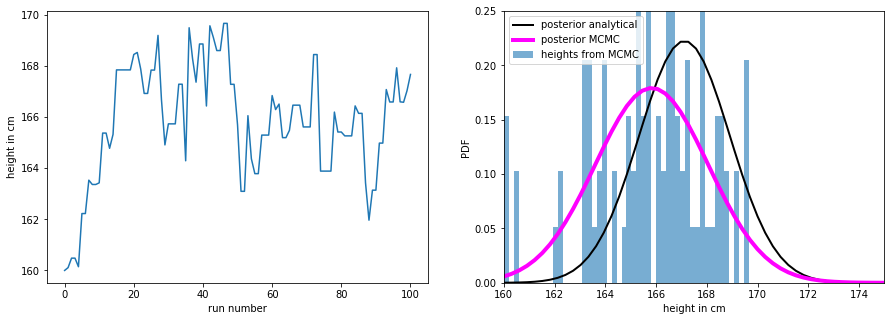

In [14]:
# tip : put the plotting routines outside the cell of the 
# MCMC otherwise you'll need to do your N runs everytime you change a plotting feature
# generate x for plotting

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(theta_current) 
plt.xlabel('run number')
plt.ylabel('height in cm')

x = np.linspace(150,180,100)
posterior_mcmc=norm.pdf(x, mean_mcmc, std_mcmc)

plt.subplot(122)
#plots the analytic posterior
plt.plot(x,norm.pdf(x,posterior_mean,posterior_std),label='posterior analytical',c='black',lw=2)

# plots the mcmc generated posterior
plt.hist(theta_current,bins=50,density=True,label='heights from MCMC',alpha=0.6)
plt.plot(x,posterior_mcmc,label = 'posterior MCMC',c='magenta',lw=4)
plt.legend(loc='upper left')
plt.xlim(160,175)
plt.ylim(0,0.25)
plt.xlabel('height in cm')
plt.ylabel('PDF')

You can see that the above plots are not great - *left*- it looks like our MCMC is not behaving very well and is very clumpy, *right* - we expect the posterior to be a normal (see Chapter 6) and yet the values of heights we've gotten out of the MCMC are not very normal.  The analytical posterior (black) is also not very close to the MCMC posterior...

Let's instead try and N of 100,000 and see what happens. This will take much longer to run but will be worth the wait!

In [15]:
N_mcmc = 100000
theta_current = np.zeros(N_mcmc+1)
# use our prior as a guess
theta_current[0] = 160.

# choose a value for width of normal distribution to get the step in age
# this is between the prior and the likelihood values
sigma_mcmc = 2

for i in range(N_mcmc):
    p_current = posterior(theta_current[i]) # put in posterior equations
    dtheta = np.random.normal(0,sigma_mcmc) # randomally draw a value of theta to trial
    theta_proposed = theta_current[i] + dtheta #get new theta
    p_proposed = posterior(theta_proposed)
    
    #  keep value if probability proposed theta greater than the current prob
    if p_proposed > p_current: 
        theta_current[i+1] = theta_proposed
    else:
    # if probability lower
    # use the ratios of probability to define probability of the move
        p_new_move = p_proposed/p_current
        # generate random number for probability
        u_random = np.random.uniform(0,1)
        # if u_random < p_new_move, then accept, if not, reject
        if u_random <= p_new_move:
            theta_current[i+1] = theta_proposed
        else:
            theta_current[i+1] = theta_current[i]

# get mean + std from mcmc generated samples
mean_mcmc=np.mean(theta_current)
std_mcmc=np.std(theta_current)

print('The mean height from the MCMC is {:.2f} +/- {:.2f} cm'.format(mean_mcmc,std_mcmc))

The mean height from the MCMC is 167.15 +/- 1.78 cm


Text(0, 0.5, 'PDF')

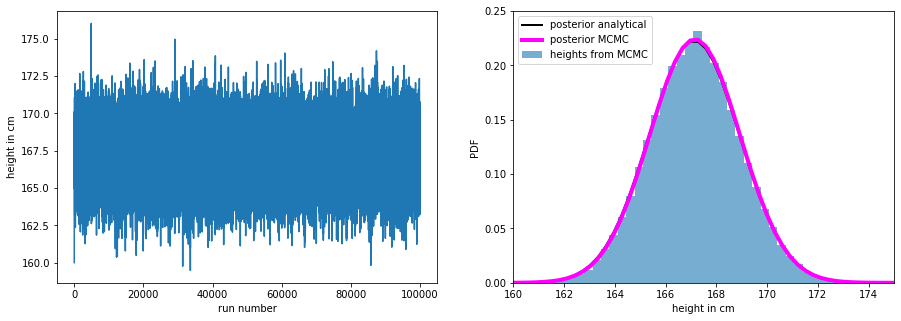

In [16]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(theta_current) 
plt.xlabel('run number')
plt.ylabel('height in cm')

x = np.linspace(150,180,100)
posterior_mcmc=norm.pdf(x, mean_mcmc, std_mcmc)

plt.subplot(122)
#plots the analytic posterior
plt.plot(x,norm.pdf(x,posterior_mean,posterior_std),label='posterior analytical',c='black',lw=2)

# plots the mcmc generated posterior
plt.hist(theta_current,bins=50,density=True,label='heights from MCMC',alpha=0.6)
plt.plot(x,posterior_mcmc,label = 'posterior MCMC',c='magenta',lw=4)
plt.legend(loc='upper left')
plt.xlim(160,175)
plt.ylim(0,0.25)
plt.xlabel('height in cm')
plt.ylabel('PDF')

This is much better - things look like they're more stable now and now we can see the MCMC posterior data returns a gaussian and agrees well with the analytical posterior for a normal likelihood and prior.

***

## Pitfalls

1. As you can imagine, it is possible to unknowingly start your MCMC a long way from the underlying peak of the target distribution, and so the first $n$ points in the chain are usually rejected, since their location may be biased. This period of $n$ skipped positions is known as the **burn in**. Given that modern computers are extremely fast, it is common to throw away many thousands of points to ensure that the remaining sample is not biased by the initial conditions. Deciding how many points to skip depends on how well you think the MCMC is doing at sampling your target distribution. We will discuss this more further down. Generally speaking, if you start close to the peak of the target distribution, your burn-in will be shorter than if you start in a region of low (and flat) probability.


2. Clearly the value of $\Delta_{\theta}$ is also something that needs to considered carefully. If $\Delta_{\theta}$ is too small, then the MCMC will explore the parameter space very slowly. It will be accurate, and because $P(\theta_{proposed}) / P(\theta_{current}) \sim 1$, the proposals will often be accepted,  but clearly it take a very long time to fully sample the distribution. This is a particular problem if you also happen to start your MCMC far away from the peak.


3. On the other hand, if you make $\Delta_{\theta}$ too large, the ratio of $P(\theta_{proposed}) / P(\theta_{current})$ will often be very small, and so there will be very little chance of accepting the proposed move. The result is that you will have a large number of duplicate values in your MCMC sample. One benefit of the large $\Delta_{\theta}$ is that it can often move itself out from regions of low probability. However it can also overshoot peaks!


4. Another problem associated with the choice of  $\Delta_{\theta}$ is the clustering of data points. This tends to happen for cases in which the proposal distribution is Normal, and $\Delta_{\theta}$ is too small. The cluster arises from the probabilities distribution of the Normal -- although it is centred narrowly around $\theta_{current}$ there is a non-zero probability of making a big jump (several $\sigma$ away). So the MCMC chain tends to loiter in a spot for a long time, before making a big jump to a new patch of the parameter space.


5. Another problem with MCMC is that it can get stuck in local maxima. For example, imagine case with a strong prior and conflicting data. In this case there will be (at least) two peaks, one from the data and one from prior. The MCMC walk might loiter around one of the these peaks for a while, before venturing down the slope to lower probability regions of the parameter space. What that occurs, there is a chance that the walk then wander up the other, unexplored peak, but there's also a chance that it simply goes back up the peak that it just came from! Note that this well-explored peak might not be the global maximum - it could be a small, relatively insignificant peak at an overall low probability, but one that we just happened to stumble upon due to our choice of initial starting position. We then have to wait a very long time before the points start to represent the overall distribution.


What all this means is it takes a bit of trial and error to get the standard Metropolis algorithm to converge in the way you want and it can be *very sensitive to your initial guess*. However, it has the advantage that it is very easy to code, and that computers are now fast enough to allow you explore the parameter space and fine-tune the sampler to hone in on the optimal values.  We can also do some tests to determine if the MCMC is acting sensibly.

## Testing for convergence

The simplest way to assess convergence is to monitor the properties of your sample until any trends have disappeared, such as an increasing mean, or oscillating skewness, etc. It is also good monitor this over different lengths of $N$ within your chain. For example, after 1 million points have been generated, you could try comparing the various moments of the first 1000 points, with the last. This will also start to give you a feel for where the burn-in period ends. Or you plot the mean, std, variance for each 100 points, and see at which point in the chain these values start to settle down.

We can derive an acceptance ratio for our data based on the number of proposed values that are accepted versus the total number of steps: $N_{\mbox{accepted}}/N_{\mbox{steps}}$, which should be $\sim 0.4$ for 1-dimensional cases like the ones here.

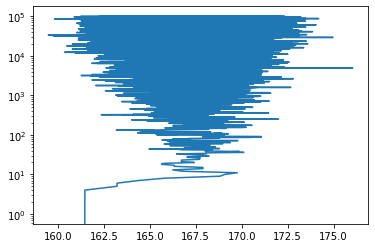

In [19]:
# let's generate the walk for plotting
x_mcmc=np.linspace(0,N_mcmc,N_mcmc+1)

plt.semilogy(theta_current,x_mcmc)

In code speak - this would look like

`burnin=100
burnt_sample = sample[burnin:]`

This would take out the first 100 entries in your MCMC output.

A more worrying problem is the case in which your well sampled chain has become stuck in a not very important peak. Thankfully, a simple solution is at hand: do several chains with different starting positions and/or step sizes, and allow them to independently explore the pdf. Again you can compare the properties of the various chains at different stages, to see how well they are doing. If one chain has a very different mean, say, than the others, then it is likely that it has become stuck in far-off maximum. 

For cases where the MCMC results look clumpy even for a sensible number of walks ($N>10000$), you can perform *thinning*, whereby you only accept each $n$th value from the chain and throw away the rest. To decide on $n$,  you can either simply look at the data.

To thin the data in a code, this would look like
`length=20
independentsamples = sample[::length]`

This would pull out numbers every 20 points+initial guess such that you would return 6 independent samples if your length is 20 and your MCMC was only 100 trials.  If you did 1000 trials, this would then return 51 values from your original 1000.

You could also perform some sort of correlation statistic on sets of $n$ points, to see where the correlations end. To do this we want to check  how correlated a sample $i$ is to sample $i-1$, $i-2$ etc.  Matplotlib has a library for this `plt.accor(data-mean(data),maxlags=10)`, see example below.  This checks the differences in a sample of data ahead of the current sample $X_{i+k}$, where the current sample is $X_i$.  We refer to the lag $k$ as the range ahead of the current sample:

$r_k = \dfrac{\sum (X_i - \hat{X})(X_{i+k}-\hat{X})}{\sum (X_i - \hat{X})^2}.$

Another convergence test which can be rather powerful is testing what you get if you re-run your MCMC with different initial conditions or step sizes. If they have converged, they should give you the same result.

**Important**

The values returned from MCMC are not strictly the same as those that you would get from, say, from a real random process, due to the pseudo-random number generates we have in computers. 

### <font color=#4290C4>Example</font>

Plot the autocorrelation in the random sample from the top of this notebook.

###  <font color=#c38241> Solution</font>

Click below to see the solution.

Text(0.5, 0, 'Number of lags')

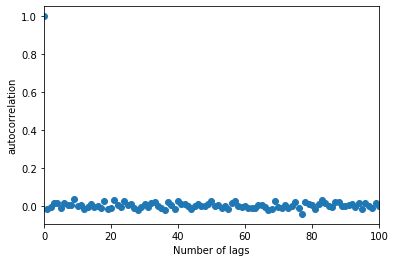

In [20]:
#plot autocorrelation for the random data generated above
plt.acorr(randomG_data-np.mean(randomG_data), maxlags=100, normed=True, usevlines=False);
plt.xlim(0,100)
plt.ylabel('autocorrelation')
plt.xlabel('Number of lags')

What about running different starting positions/initial guesses or different step sizes. This can be done by running the MCMC over a number of different theta_current values for example.

<img src="https://github.com/haleygomez/Data-Analysis-2021/raw/master/blended_exercises/Chapter%207/initial.png" width="400">

Notice how they all converge.

Below we shown an illustration of the resulting MCMC for a large number of trials but with too small (left) and too large (right) a step size.  If $\Delta_{\theta}$ is too small, then the MCMC will explore the parameter space very slowly. It will be accurate, and because $P(\theta_{proposed}) / P(\theta_{current}) \sim 1$, the proposals will often be accepted,  but clearly it take a very long time to fully sample the distribution. This is a particular problem if you also happen to start your MCMC far away from the peak.  If you make $\Delta_{\theta}$ too large, the ratio of $P(\theta_{proposed}) / P(\theta_{current})$ will often be very small, and so there will be very little chance of accepting the proposed move. The result is that you will have a large number of duplicate values in your MCMC sample. It can also overshoot peaks!

A too small stepsize can lead to the MCMC not converging due to a very slow exploration of the probability space over a small range (top figure) or even too large (bottom figure) a stepsize can result in the MCMC jumping too much and potentially missing locations of probability peaks.

<tr>
<td><img src="https://github.com/haleygomez/Data-Analysis-2021/raw/master/blended_exercises/Chapter%207/smallstep.png" width="400"> 
<td><img src="https://github.com/haleygomez/Data-Analysis-2021/raw/master/blended_exercises/Chapter%207/largestep.png" width="400">
</tr>

***

# How does this magic work?

Quote from [Stack Exchange answer](https://stats.stackexchange.com/questions/165/how-would-you-explain-markov-chain-monte-carlo-mcmc-to-a-layperson/438)

> Imagine you want to find a better strategy to beat your friends at the board game Monopoly. Simplify the stuff that matters in the game to the question: which properties do people land on most? The answer depends on the structure of the board, the rules of the game and the throws of two dice. One way to answer the question is this. Just follow a single piece around the board as you throw the dice and follow the rules. Count how many times you land on each property (or program a computer to do the job for you). Eventually, if you have enough patience or you have programmed the rules well enough in you computer, you will build up a good picture of which properties get the most business and probability of landing there. This should help you win more often.  Where you land next only depends on where you are now, not where you have been before and the specific probabilities are determined by the distribution of throws of two dice.   This is basically a combination of the monte carlo (playing the game lots of times and markov chain - next step only depends on current location). 

From above, the MCMC uses

$p_{\rm move} = \dfrac{ P(\theta_{\rm proposed}) }{ P(\theta_{\rm current})}$

we get an acceptance probability. You can already see that if $p_{\rm proposed}$ is larger, that probability will be $> 1$ and we will definitely accept. However, if $p_{\rm current}$ is larger, say twice as large, there will be a 50% chance of moving there.

We can show this by computing the acceptance ratio over the normalized posterior and seeing how it's equivalent to the acceptance ratio of the unnormalized posterior (lets say $\theta_{\rm current}$ is our current position, and $\theta_{\rm proposed}$ is our proposal),

$\dfrac{P(\theta_{\rm proposed}|x)}{P(\theta_{\rm current}|x)} = \dfrac{\dfrac{P(x|\theta_{\rm proposed})P(\theta_{\rm proposed})}{P(x)}}{\dfrac{P(x|\theta_{\rm current})P(\theta_{\rm current})}{P(x)}}$

$\dfrac{P(\theta_{\rm proposed}|x)}{P(\theta_{\rm current}|x)} = \dfrac{P(x|\theta_{\rm proposed})P(\theta_{\rm proposed})}{P(x|\theta_{\rm current})P(\theta_{\rm current})}$

In words, dividing the posterior of proposed parameter setting by the posterior of the current parameter setting, $P(x)$ - that nasty quantity we can't compute - gets canceled out. So we're actually dividing the full posterior at one position by the full posterior at another position (no magic here). That way, we are visiting regions of high posterior probability relatively more often than those of low posterior probability.

***

Now you are ready to tackle the **Chapter 7 quiz** on Learning Central and the [Chapter 7 yourturn notebook](https://github.com/haleygomez/Data-Analysis-2021/blob/master/blended_exercises/Chapter%207/Chapter7_yourturn.ipynb).